**Chapter 6, end-of-chapter problems**

The purpose of this notebook is to run code for end-of-chapter problems.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.interpolate import griddata

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [14]:
def standardize(vec):
    return vec - np.mean(vec) / np.std(vec)

<IPython.core.display.Javascript object>

# Problem 6M2, Z as a pipe

Sometimes, in order to avoid multicollinearity, people inspect pairwise correlations among predictors before including them in a model. This is a bad procedure, because what matters is the conditional association, not the association before the variables are included in the model. To highlight this, consider the DAG X → Z → Y. Simulate data from this DAG so that the correlation between X and Z is very large. Then include both in a model prediction Y. Do you observe any multicollinearity? Why or why not? What is different from the legs example in the chapter?

Generate correlated values using `np.random.multivariate_normal`.

See [here](https://stackoverflow.com/questions/16024677/generate-correlated-data-in-python-3-3).

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


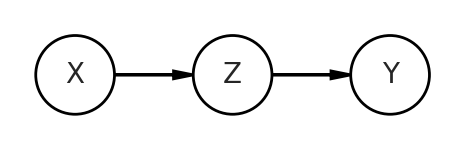

<IPython.core.display.Javascript object>

In [3]:
pipe_dag = CausalGraphicalModel(
    nodes=["X", "Z", "Y"],
    edges=[
        ("X", "Z"),
        ("Z", "Y"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "X": (0, 0),
    "Z": (1, 0),
    "Y": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


In [7]:
# # Used above code, ended up using repo code

# num_samples = 200

# # The desired mean values of the sample.
# mu = np.array([0, 10.0])

# # The desired covariance matrix.
# r = np.array(
#     [
#         [
#             3.40,
#             2.75,
#         ],
#         [2.75, 3.50],
#     ]
# )

# # Generate the random samples.
# y_mat = np.random.multivariate_normal(mu, r, size=num_samples)
# x = y_mat[:, 0]
# z = y_mat[:, 1]

# np.corrcoef(x, z)

# I'm asked to see how to predict Y. The values of Y are not stated but I can use this DAG to show it should be correlated.
# y = np.random.normal(loc=5 * z)

<IPython.core.display.Javascript object>

In [8]:
# simulate data according to the DAG
x = np.random.normal(size=100)
z = np.random.normal(loc=4 * x)
y = np.random.normal(loc=0.4 * z)

<IPython.core.display.Javascript object>

In [9]:
print(x.mean(), z.mean(), y.mean())

-0.08784971508839351 -0.27253984402041453 -0.15339871814080472


<IPython.core.display.Javascript object>

(array([ 3.,  4.,  9., 12., 29., 14., 17.,  7.,  1.,  4.]),
 array([-4.83842533e+00, -3.87106827e+00, -2.90371121e+00, -1.93635415e+00,
        -9.68997087e-01, -1.64002657e-03,  9.65717034e-01,  1.93307409e+00,
         2.90043116e+00,  3.86778822e+00,  4.83514528e+00]),
 <BarContainer object of 10 artists>)

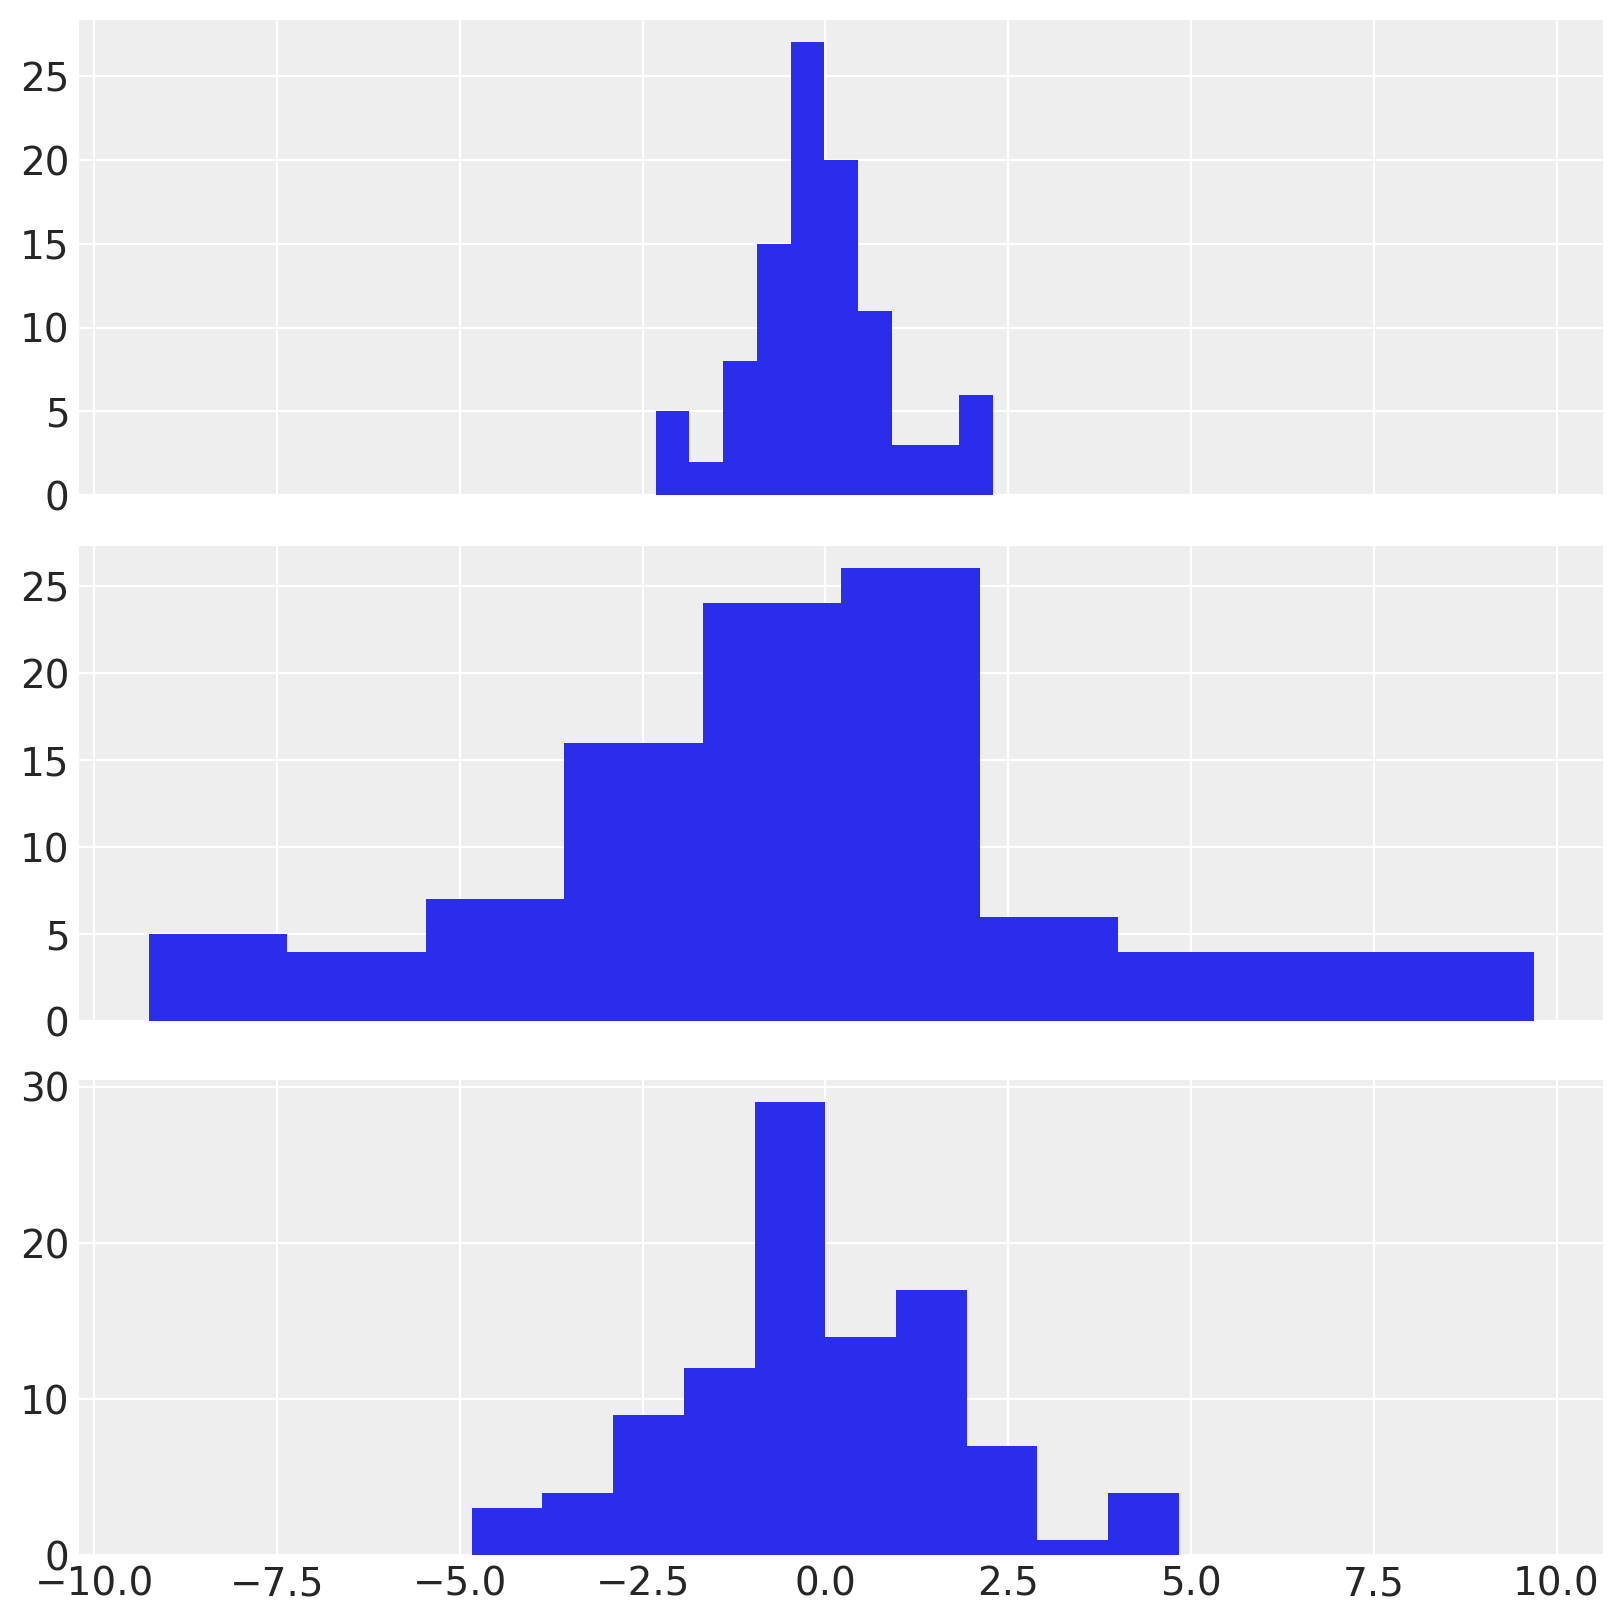

<IPython.core.display.Javascript object>

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

ax1.hist(x)
ax2.hist(z)
ax3.hist(y)

In [12]:
sx, sz, sy = standardize(x), standardize(z), standardize(y)
data = pd.DataFrame(np.array([sx, sy, sz]).T, columns=["sx", "sy", "sz"])
data.corr()  # get the correlation matrix

,sx,sy,sz
sx,1.000000,0.801161,0.964004
sy,0.801161,1.000000,0.840606
sz,0.964004,0.840606,1.000000


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'z vs. y')

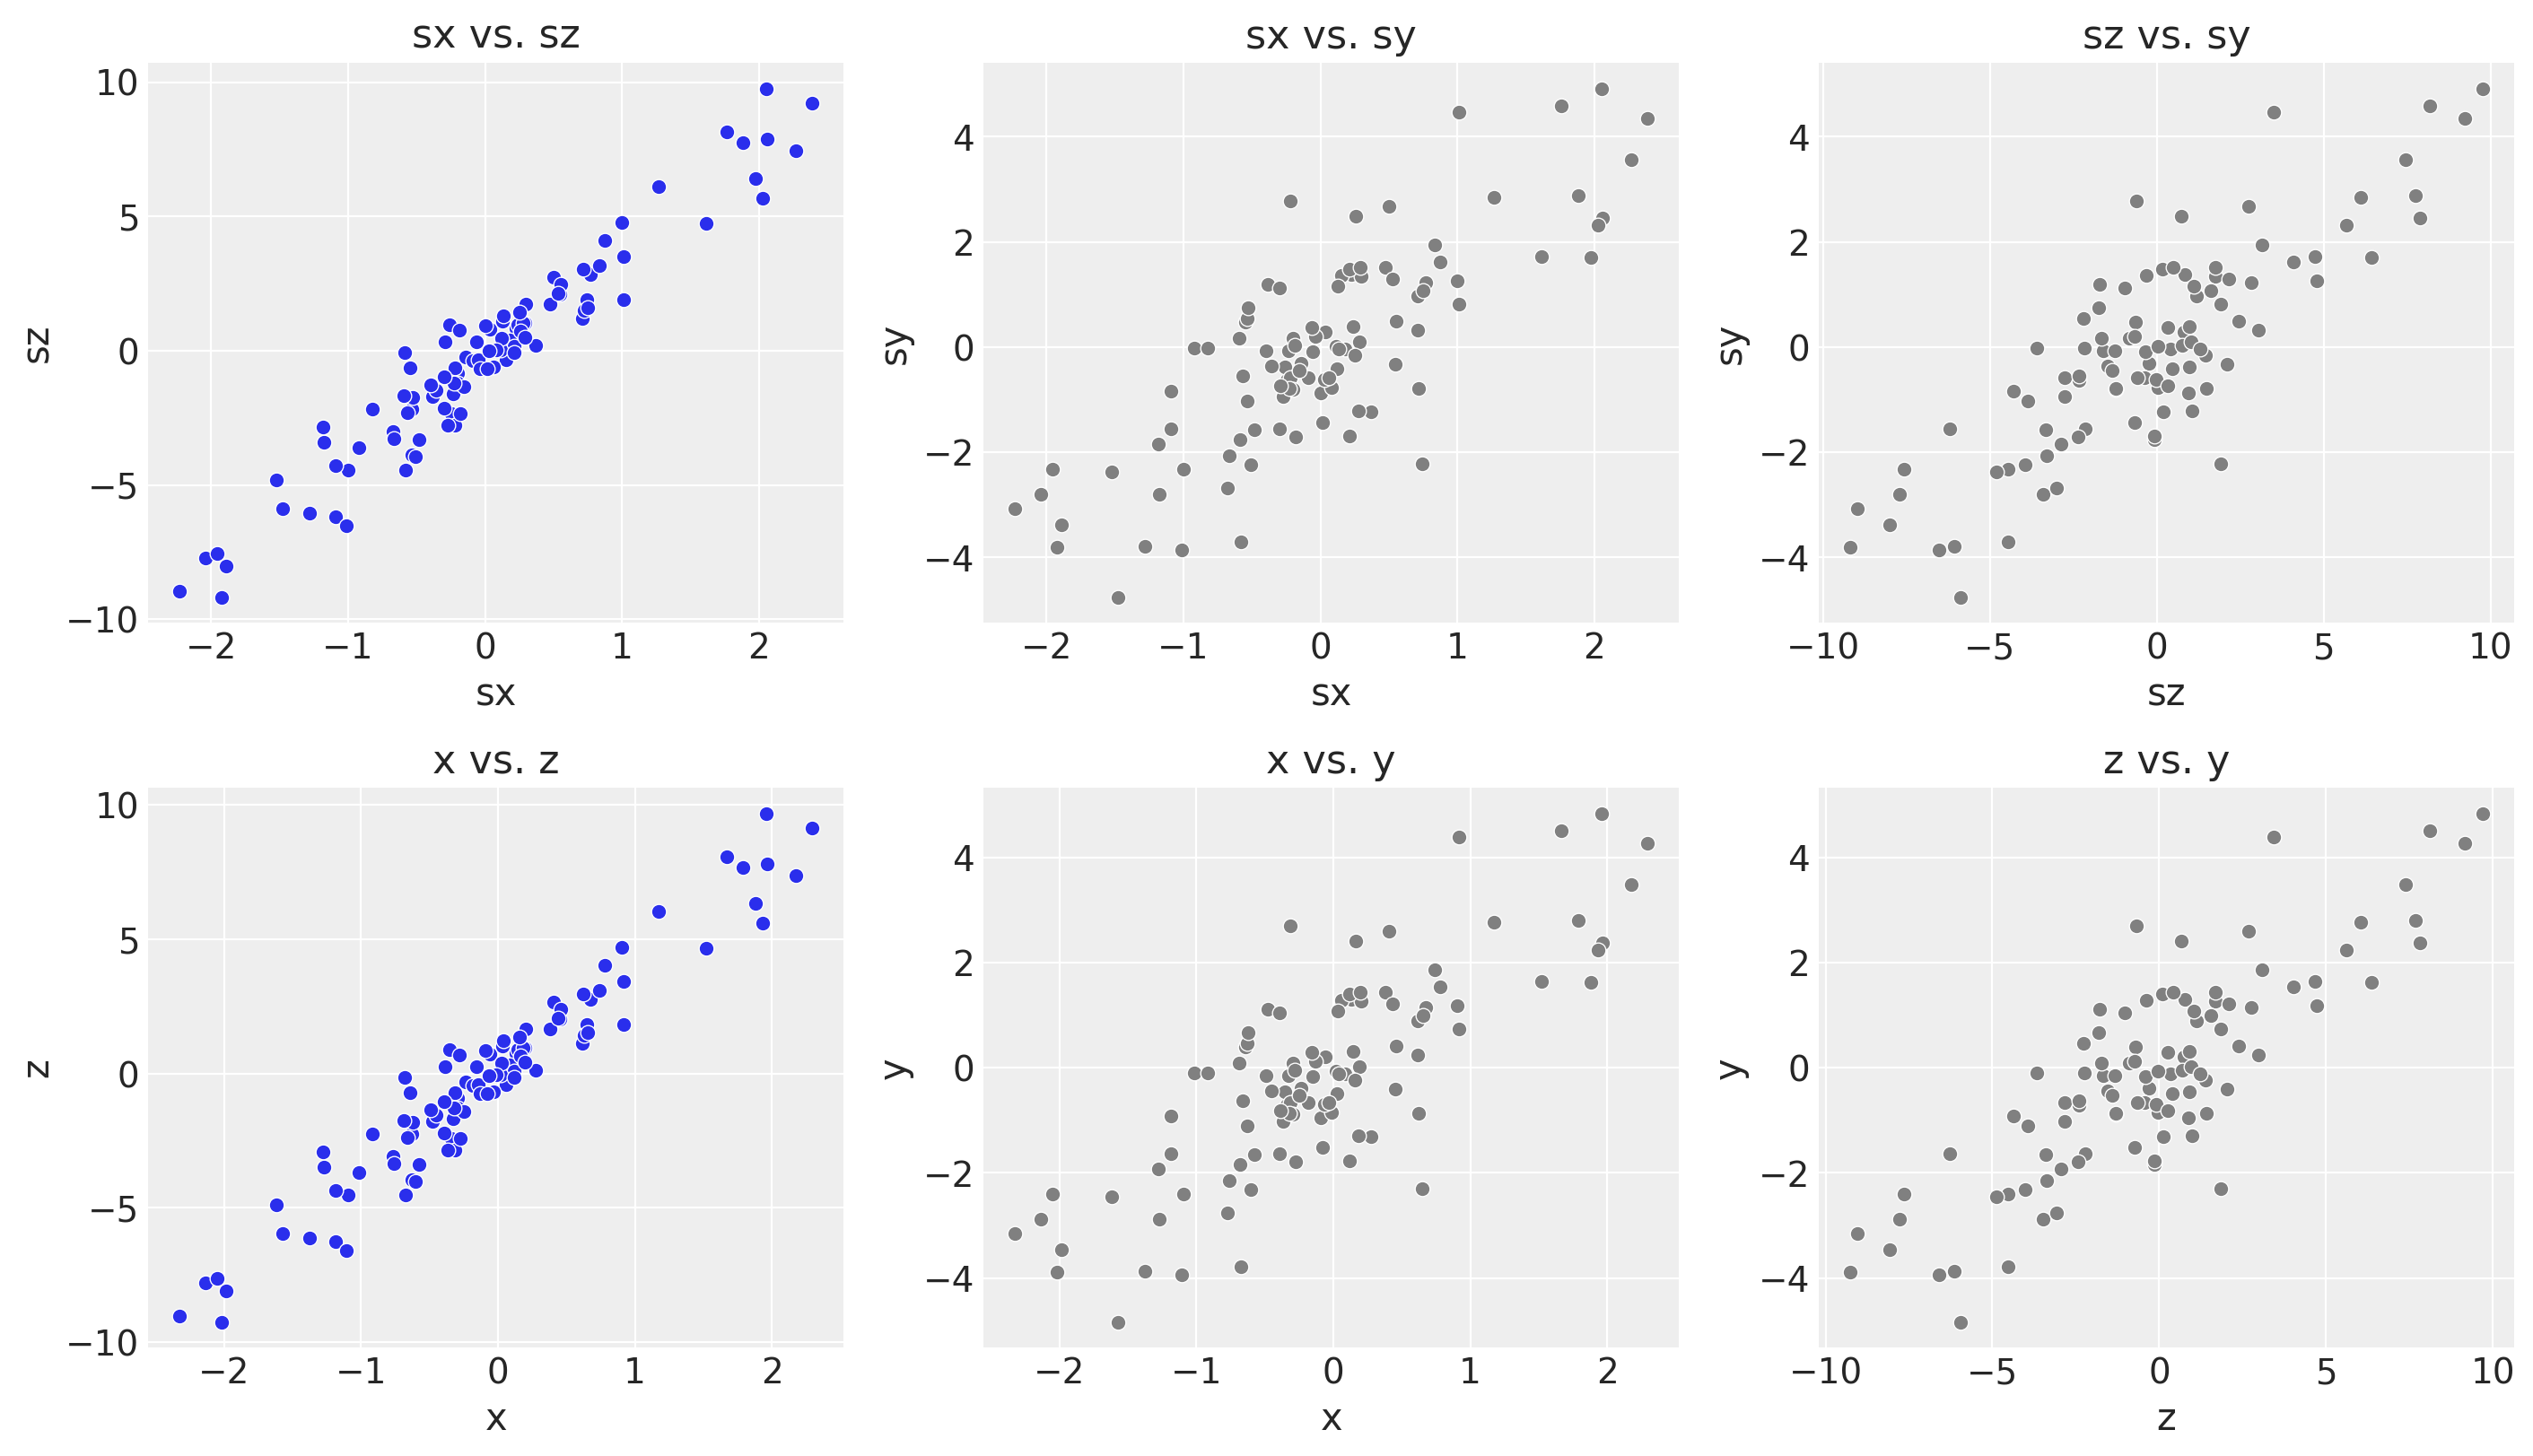

<IPython.core.display.Javascript object>

In [13]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))
sns.scatterplot(data=data, x=sx, y=sz, ax=ax1)
ax1.set_xlabel("sx")
ax1.set_ylabel("sz")
ax1.set_title("sx vs. sz")

sns.scatterplot(data=data, x=sx, y=sy, ax=ax2, color="gray")
ax2.set_xlabel("sx")
ax2.set_ylabel("sy")
ax2.set_title("sx vs. sy")

sns.scatterplot(data=data, x=sz, y=sy, ax=ax3, color="gray")
ax3.set_xlabel("sz")
ax3.set_ylabel("sy")
ax3.set_title("sz vs. sy")

sns.scatterplot(data=data, x=x, y=z, ax=ax4)
ax4.set_xlabel("x")
ax4.set_ylabel("z")
ax4.set_title("x vs. z")

sns.scatterplot(data=data, x=x, y=y, ax=ax5, color="gray")
ax5.set_xlabel("x")
ax5.set_ylabel("y")
ax5.set_title("x vs. y")

sns.scatterplot(data=data, x=z, y=y, ax=ax6, color="gray")
ax6.set_xlabel("z")
ax6.set_ylabel("y")
ax6.set_title("z vs. y")

## Include both X and Z as predictors

In [14]:
# predict y with both x and z as predictors
with pm.Model() as pipe:
    a = pm.Normal("a", mu=0, sd=0.2)  # arbitrary parameters
    bx = pm.Normal("bx", mu=0, sd=0.5)  # arbitrary parameters
    bz = pm.Normal("bz", mu=0, sd=0.5)  # arbitrary parameters
    mu = a + bx * sx + bz * sz
    sigma = pm.Exponential("sigma", 5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=sy)
    sample = pm.sample(draws=250, chains=4, return_inferencedata=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 13 seconds.


<IPython.core.display.Javascript object>

In [15]:
# az.plot_forest(sample)  # don't need to plot
az.summary(sample)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.018,0.093,-0.129,0.164,0.003,0.003,767.0,564.0,776.0,723.0,1.01
bx,-0.100,0.322,-0.624,0.388,0.017,0.012,352.0,352.0,350.0,308.0,1.01
bz,0.451,0.082,0.316,0.573,0.004,0.003,398.0,398.0,396.0,437.0,1.01
sigma,1.036,0.077,0.909,1.150,0.003,0.002,551.0,551.0,543.0,326.0,1.02


<IPython.core.display.Javascript object>

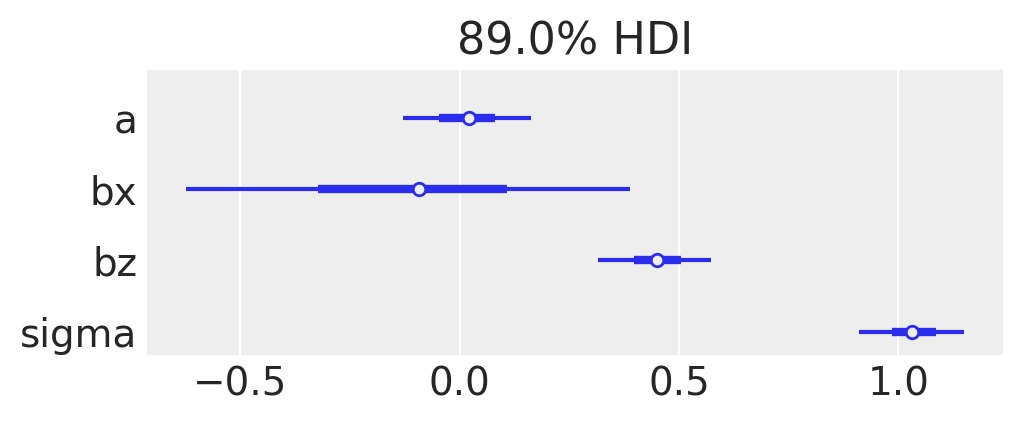

<IPython.core.display.Javascript object>

In [49]:
# _ = az.plot_forest(sample, var_names=["~mu"], combined=True, figsize=[5, 2])
_ = az.plot_forest(sample, combined=True, figsize=[5, 2])

**Interpretation**

The DAG shows Z as a pipe. It's a confound that allows information to pass from X to Y through Z. If you include it in the model (condition on it), then you are closing the information. Here, we see that bx (the coefficient between x and y) looks like it's around zero even though we can see clearly from the graphs that there is a correlation, but Z's coefficient is non-zero.

## Only X as predictor

In [17]:
# predict y with only x as a predictor
with pm.Model() as pipe:
    a = pm.Normal("a", mu=0, sd=0.2)  # arbitrary parameters
    bx = pm.Normal("bx", mu=0, sd=0.5)  # arbitrary parameters
    mu = a + bx * sx
    sigma = pm.Exponential("sigma", 5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=sy)
    sample2 = pm.sample(draws=250, chains=4, return_inferencedata=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 10 seconds.


<IPython.core.display.Javascript object>

In [18]:
az.summary(sample2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.061,0.108,-0.226,0.109,0.003,0.003,1337.0,624.0,1350.0,689.0,1.01
bx,1.548,0.123,1.344,1.727,0.003,0.002,1319.0,1308.0,1380.0,546.0,1.00
sigma,1.149,0.086,1.009,1.278,0.002,0.002,1684.0,1621.0,1753.0,818.0,1.00


<IPython.core.display.Javascript object>

Now we see that bx is significant but bz is not!

Text(0.5, 0, 'sum of bx and br')

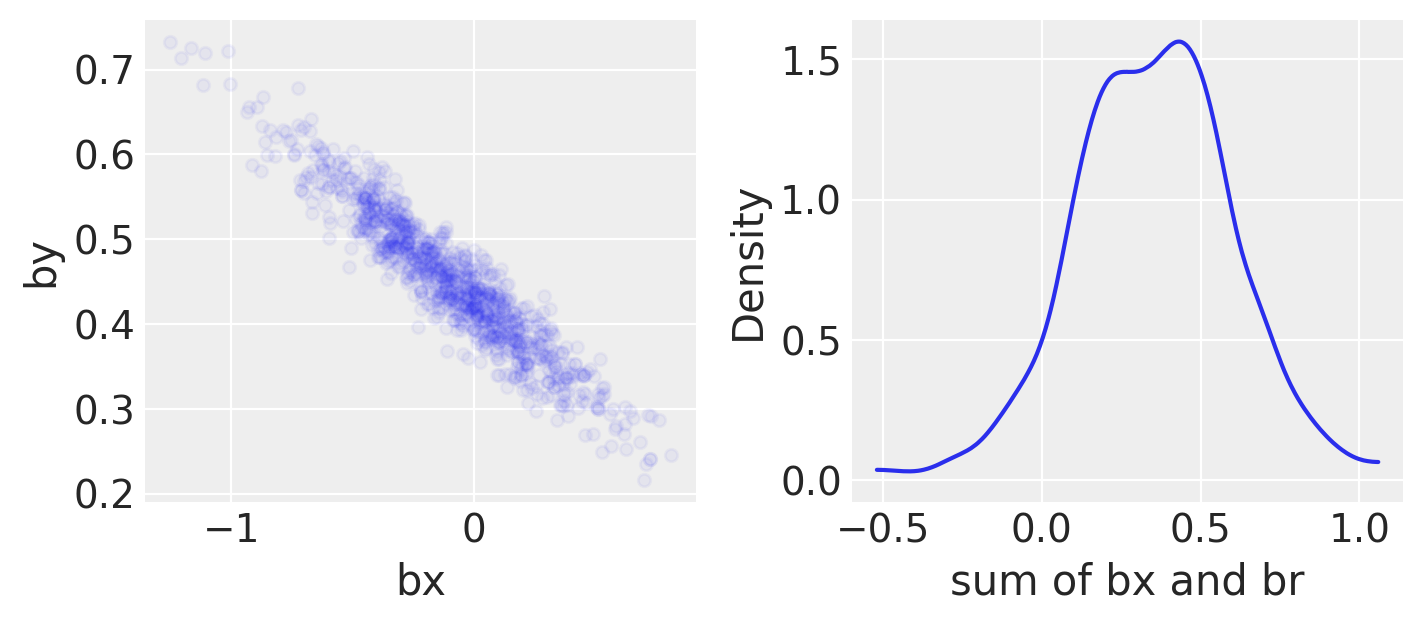

<IPython.core.display.Javascript object>

In [19]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[7, 3])

# code 6.5
ax1.scatter(sample.posterior["bx"], sample.posterior["bz"], alpha=0.05, s=20)
ax1.set_xlabel("bx")
ax1.set_ylabel("by")

# code 6.6
az.plot_kde(sample.posterior["bx"] + sample.posterior["bz"], ax=ax2)
ax2.set_ylabel("Density")
ax2.set_xlabel("sum of bx and br")

In [20]:
sample.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 250)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 242 243 244 245 246 247 248 249
Data variables:
    a        (chain, draw) float64 -0.04887 -0.09022 ... -0.0947 -0.06054
    bx       (chain, draw) float64 0.1446 0.1827 0.2159 ... -0.3816 -0.3254
    bz       (chain, draw) float64 0.4047 0.3937 0.3786 ... 0.4885 0.4885 0.5142
    sigma    (chain, draw) float64 0.9581 0.9443 0.9603 ... 0.881 0.881 0.9183
Attributes:
    created_at:                 2021-04-29T15:53:25.742543
    arviz_version:              0.11.1
    inference_library:          pymc3
    inference_library_version:  3.11.0
    sampling_time:              12.835628986358643
    tuning_steps:               1000

<IPython.core.display.Javascript object>

In [18]:
sample2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

## Only Z as predictor

In [21]:
# predict y with only z as a predictor
with pm.Model() as pipe:
    a = pm.Normal("a", mu=0, sd=0.2)  # arbitrary parameters
    bz = pm.Normal("bz", mu=0, sd=0.5)  # arbitrary parameters
    mu = a + bz * sz
    sigma = pm.Exponential("sigma", 5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=sy)
    sample3 = pm.sample(draws=250, chains=4, return_inferencedata=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8867520905371928, but should be close to 0.8. Try to increase the number of tuning steps.


<IPython.core.display.Javascript object>

In [22]:
az.summary(sample3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.012,0.089,-0.131,0.159,0.002,0.003,1419.0,434.0,1416.0,706.0,1.0
bz,0.429,0.028,0.384,0.472,0.001,0.001,1369.0,1306.0,1368.0,657.0,1.0
sigma,1.038,0.072,0.932,1.161,0.002,0.001,1372.0,1335.0,1402.0,738.0,1.0


<IPython.core.display.Javascript object>

# Follow-up for me


## Wrote on Discourse and Twitter

**Me**

Hi all, I'm new to this group and I literally just joined Discord. Looks like I just missed the discussion. It's funny timing though because I was working on 6M2 and I had a question on it. He says that we shouldn't just "inspect pairwise correlations among predictors before including them in a model." But it seems like we get to the right action (remove either X or Z ) even if we did. Was I missing something? Or was it just meant to show how collinearity can happen differently? (either a pipe in this question or a result of an unobserved variable with the legs example)

**ro.esta0**

Hi Ben, welcome! My take on the essence of this question is that there is no way before running the model that we could have known whether it’s a multi-collinearity or a Pipe just by gazing into the pairs plot because both of them can have identical pairs plot yet different data generating process. And in both, we can remove X or Z depending upon what causal effect we are interested in.
We could figure that out by understanding the data generating process (DAGS) or by simply let model figure that out for us.

**Me**
Thank you @ro.esta07! I looked back on the code and book again and I think I was just focusing on what X was doing. Looking more closely, I have to say ...this is wild. Let me describe what I picked up on and you can see if I have this right. In the legs example, the data generating process for the `leg_left` and `leg_right` variables was the same: randomly sample from the same normal distribution (R code 6.2 of 2nd edition). Pairs plots would show correlations between all combinations (tightest between `bl` and `br`). Including both variables in the model showed both `bl` and `br` overlapping with zero, indicative of multicollinearity (R code 6.3 and 6.4). 

In problem 6M2, the data generating process is different. I found code using the [pymc3 repo](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/End_of_chapter_problems/Chapter_6.ipynb). The process was to get a 100 samples from a normal distribution for `X`. Generate `Z` by drawing from a normal distribution whose mean is 4 times `X`. Then generate `Y` by drawing from a normal distribution whose mean is 1 times `Z`. Like the legs example, the pairs plots here would show correlations between all combinations. But in this case, including both variables in the model shows `Z`'s coefficient being non-zero. This is WILD man!


# Other things to try

- Change correlation and see how that affects coefficients > perhaps R code 6.12
- Find R code for end of chapter problems

## Do with Z as a fork instead of pipe

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


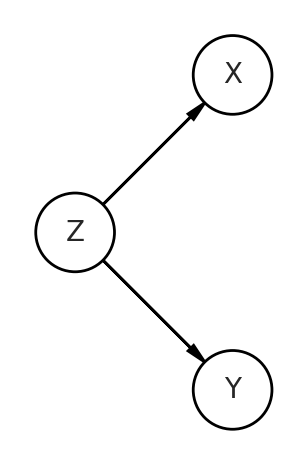

<IPython.core.display.Javascript object>

In [23]:
dag = CausalGraphicalModel(
    nodes=["X", "Z", "Y"],
    edges=[
        ("Z", "X"),
        ("Z", "Y"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "X": (1, 1),
    "Z": (0, 0),
    "Y": (1, -1),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


In [35]:
# Set z to a normal distribution with some arbitrary mean
z = np.random.normal(loc=1, size=100)

# Set both x and y to be derived from z, also by some arbitrary value

x = np.random.normal(loc=4 * z)
y = np.random.normal(loc=0.4 * z)


<IPython.core.display.Javascript object>

In [36]:
print(z.mean(), x.mean(), y.mean())

0.8690002701277958 3.5220524896408234 0.41866668856155925


<IPython.core.display.Javascript object>

(array([ 2.,  8., 13., 12., 23., 16., 16.,  7.,  2.,  1.]),
 array([-1.94802945, -1.43207647, -0.9161235 , -0.40017052,  0.11578245,
         0.63173542,  1.1476884 ,  1.66364137,  2.17959435,  2.69554732,
         3.2115003 ]),
 <BarContainer object of 10 artists>)

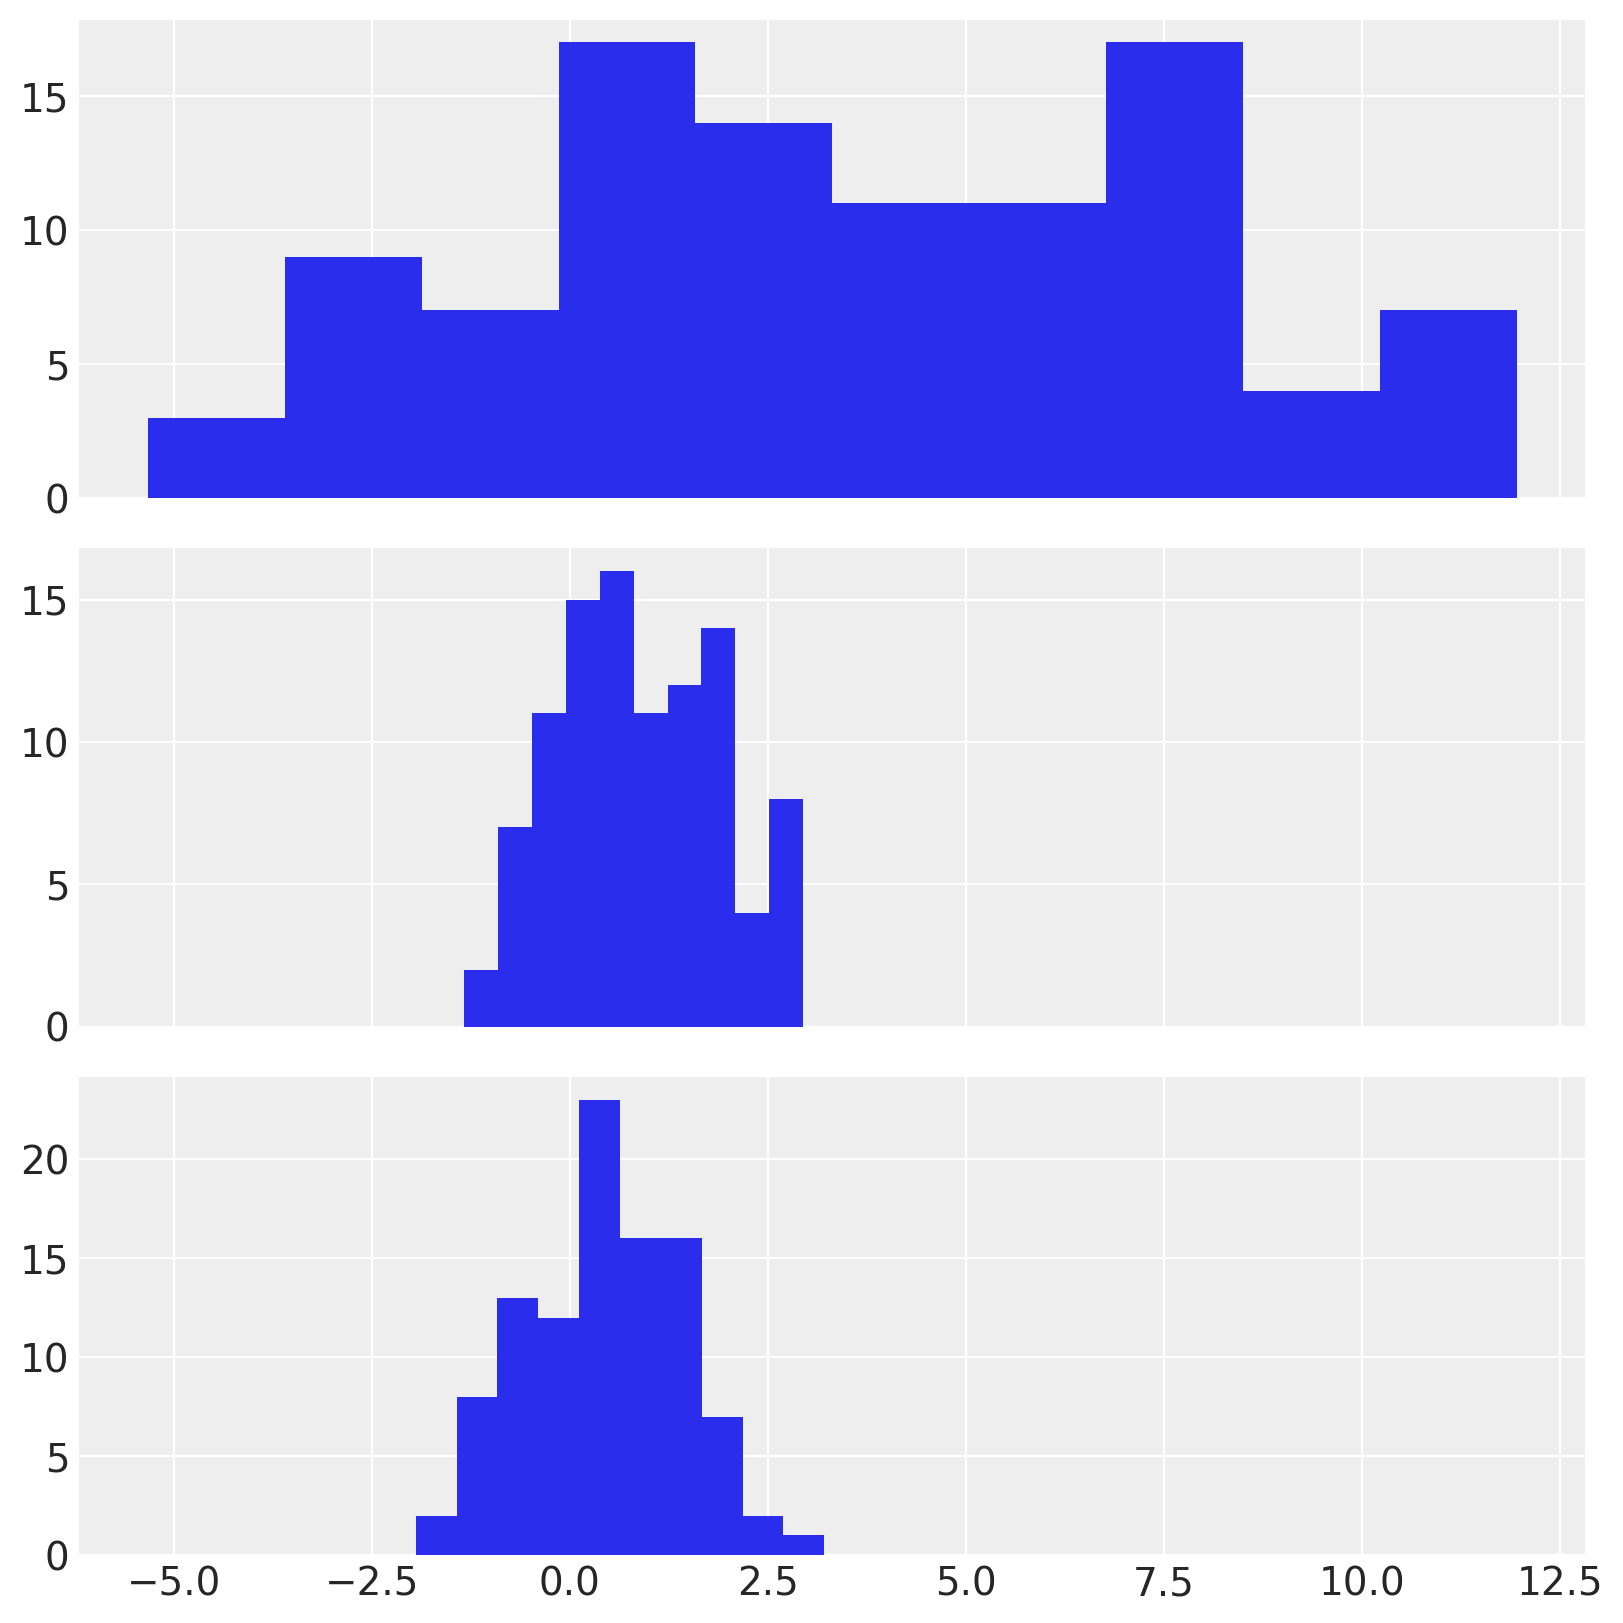

<IPython.core.display.Javascript object>

In [37]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

ax1.hist(x)
ax2.hist(z)
ax3.hist(y)

In [38]:
def standardize(vec):
    return vec - np.mean(vec) / np.std(vec)

<IPython.core.display.Javascript object>

In [39]:
sx, sz, sy = standardize(x), standardize(z), standardize(y)
df = pd.DataFrame({"sz": sz, "sx": sx, "sy": sy})
df.head()

,sz,sx,sy
0,-0.856410,-0.584107,-1.259541
1,-1.607479,-6.017500,0.095100
2,0.436335,5.526440,-0.284265
3,0.394593,3.158090,2.804944
4,0.995474,6.746476,1.084965


<IPython.core.display.Javascript object>

In [40]:
data = pd.DataFrame(np.array([sx, sy, sz]).T, columns=["sx", "sy", "sz"])
data.corr()  # get the correlation matrix

,sx,sy,sz
sx,1.00000,0.383030,0.966820
sy,0.38303,1.000000,0.377345
sz,0.96682,0.377345,1.000000


<IPython.core.display.Javascript object>

In [41]:
# combinations of given length
from itertools import combinations

# Get all combinations of length 2
comb = combinations(["sz", "sx", "sy"], 2)
# Print the obtained combinations
for i, pair in enumerate(list(comb)):
    print(i, pair)

0 ('sz', 'sx')
1 ('sz', 'sy')
2 ('sx', 'sy')


<IPython.core.display.Javascript object>

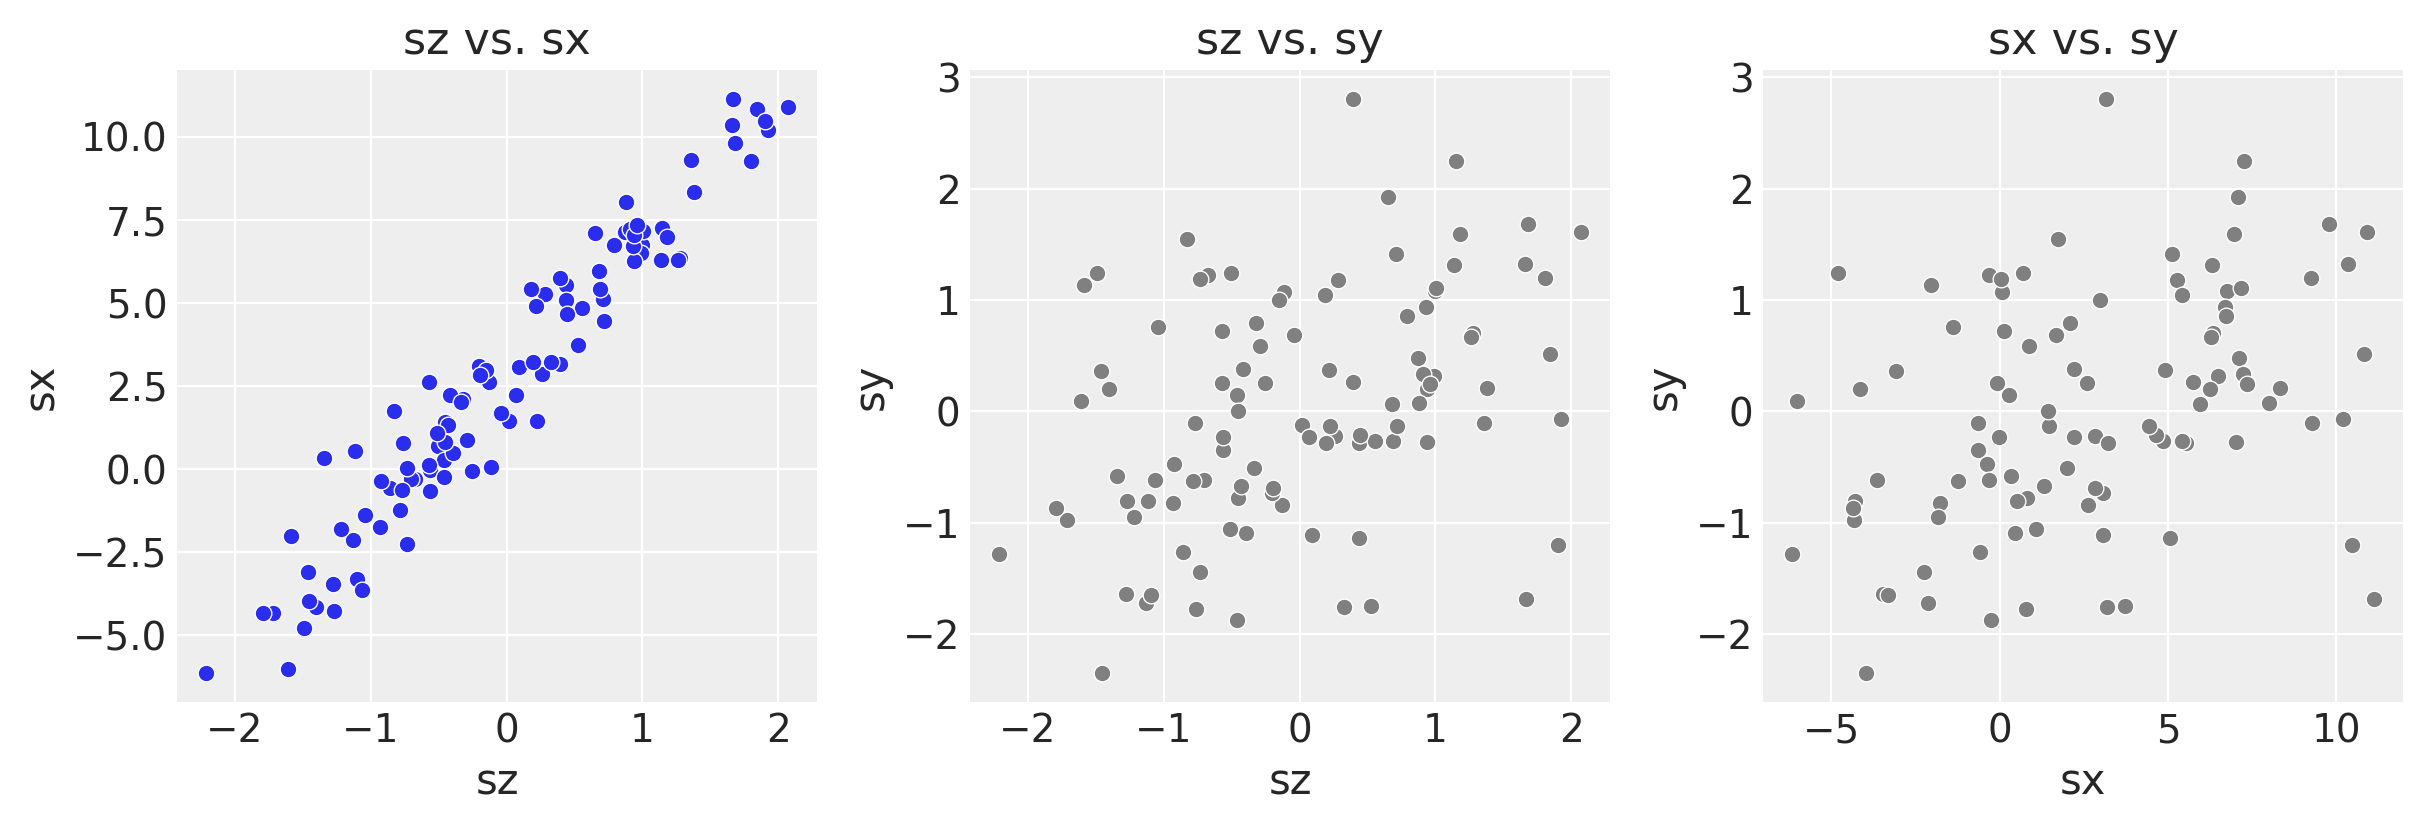

<IPython.core.display.Javascript object>

In [47]:
#3f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))

f, ax = plt.subplots(1, 3, figsize=(12,4))  # , facecolor='w', edgecolor='k')
ax = ax.ravel()

comb = combinations(["sz", "sx", "sy"], 2)

for i, pair in enumerate(list(comb)):
    #print(i, pair)
    if i > 0:
        sns.scatterplot(data=df, x=pair[0], y=pair[1], ax=ax[i], color='gray')
    else:
        sns.scatterplot(data=df, x=pair[0], y=pair[1], ax=ax[i])
    #ax[i].legend()
    ax[i].set_title(pair[0] + " vs. " + pair[1])
    ax[i].set_xlabel(pair[0])
    ax[i].set_ylabel(pair[1])

#plt.tight_layout()


### With both X and Z as predictors

In [43]:
# predict y with both x and z as predictors
with pm.Model() as m_fork:
    a = pm.Normal("a", mu=0, sd=0.2)  # arbitrary parameters
    bx = pm.Normal("bx", mu=0, sd=0.5)  # arbitrary parameters
    bz = pm.Normal("bz", mu=0, sd=0.5)  # arbitrary parameters
    mu = a + bx * sx + bz * sz
    sigma = pm.Exponential("sigma", 5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=sy)
    sample_f = pm.sample(draws=250, chains=4, return_inferencedata=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8865498129022265, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6554041724369558, but should be close to 0.8. Try to increase the number of tuning steps.


<IPython.core.display.Javascript object>

In [44]:
az.summary(sample_f)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.105,0.158,-0.341,0.157,0.009,0.007,296.0,270.0,298.0,372.0,1.00
bx,0.053,0.058,-0.039,0.146,0.003,0.003,276.0,225.0,278.0,326.0,1.00
bz,0.163,0.250,-0.252,0.535,0.015,0.011,280.0,280.0,282.0,306.0,1.01
sigma,0.954,0.070,0.849,1.065,0.004,0.003,381.0,378.0,397.0,351.0,1.01


<IPython.core.display.Javascript object>

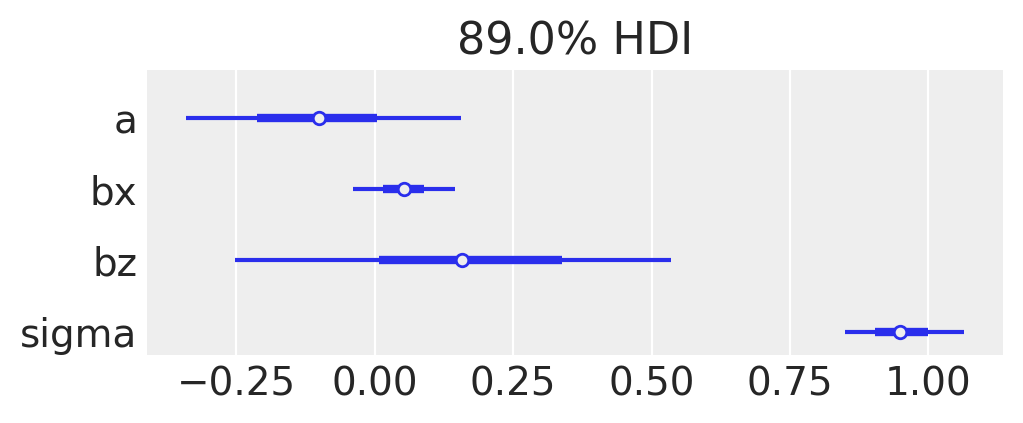

<IPython.core.display.Javascript object>

In [50]:
# az.plot_forest(sample_f, combined=True)  # don't need to plot
_ = az.plot_forest(sample_f, combined=True, figsize=[5, 2])

We see overlap with zero which is what we'd expect when doing a fork.

How about if we do another pipe but try to get the same scatter plot?

## Do another pipe, trying to replicate the scatter plot

Pipe

```
# simulate data according to the DAG
x = np.random.normal(size=100)
z = np.random.normal(loc=4 * x)
y = np.random.normal(loc=0.4 * z)
```

Fork
```
# Set z to a normal distribution with some arbitrary mean
z = np.random.normal(loc=1, size=100)
# Set both x and y to be derived from z, also by some arbitrary value
x = np.random.normal(loc=4 * z)
y = np.random.normal(loc=0.4 * z)
```

Second (this) pipe

```
# simulate data according to the DAG
x = np.random.normal(size=100)
z = np.random.normal(loc=4 * x)
y = np.random.normal(loc=0.4 * z)
```


In [126]:
# simulate data according to the DAG
x_p2 = np.random.normal(size=100)
z_p2 = np.random.normal(loc=4 * x)
y_p2 = np.random.normal(loc=0.4 * z)

In [127]:
print(z_p2.mean(), x_p2.mean(), y_p2.mean())

-30.791761439880784 -0.020436371262997636 0.3698597657864448


(array([ 1.,  4.,  4., 15., 16., 21., 19., 10.,  7.,  3.]),
 array([-2.25244459, -1.77739472, -1.30234485, -0.82729498, -0.35224511,
         0.12280476,  0.59785463,  1.0729045 ,  1.54795437,  2.02300424,
         2.49805411]),
 <BarContainer object of 10 artists>)

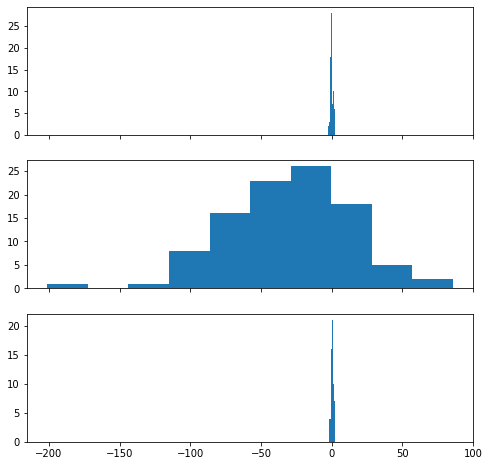

In [128]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

ax1.hist(x_p2)
ax2.hist(z_p2)
ax3.hist(y_p2)

In [130]:
sx_p2, sz_p2, sy_p2 = standardize(x_p2), standardize(z_p2), standardize(y_p2)
df = pd.DataFrame({"sz_p2":sz_p2, "sx_p2":sx_p2, "sy_p2":sy_p2})
df.head()

,sz_p2,sx_p2,sy_p2
0,-80.949787,-0.064341,0.622251
1,-60.789746,1.922684,-0.192202
2,33.111479,-0.335872,0.025595
3,-25.418594,2.456482,0.206955
4,3.463191,1.192715,-0.639934


In [131]:
data_p2 = pd.DataFrame(np.array([sx_p2, sy_p2, sz_p2]).T, columns=["sx_p2", "sy_p2", "sz_p2"])
data_p2.corr()  # get the correlation matrix

,sx_p2,sy_p2,sz_p2
sx_p2,1.000000,-0.187721,0.179219
sy_p2,-0.187721,1.000000,-0.421275
sz_p2,0.179219,-0.421275,1.000000


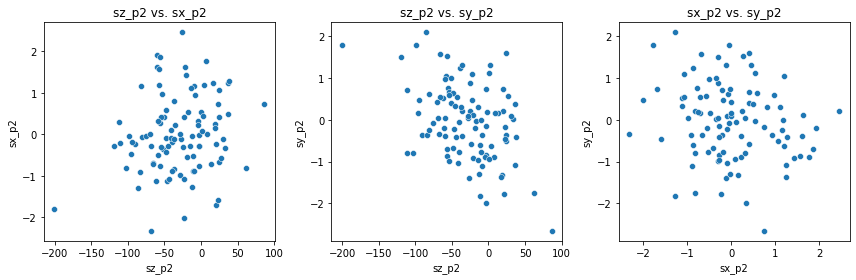

In [132]:
f, ax = plt.subplots(1, 3, figsize=(12,4))
ax = ax.ravel()

comb = combinations(["sz_p2", "sx_p2", "sy_p2"], 2)

for i, pair in enumerate(list(comb)):
    sns.scatterplot(data=df, x=pair[0], y=pair[1], ax=ax[i])
    ax[i].set_title(pair[0] + " vs. " + pair[1])
    ax[i].set_xlabel(pair[0])
    ax[i].set_ylabel(pair[1])

plt.tight_layout()

# Problem 6M3

Learning to analyze DAGs requires practice. For each of the four DAGs below, state which variables, if any, you must adjust for (condition on) to estimate the total causal influence of X on Y.

# Problem 6H1

Use the Waffle House data, data(WaffleDivorce), to find the total causal influence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.

Two possible models, as shown by the book.

## Create the DAG and find conditional independencies

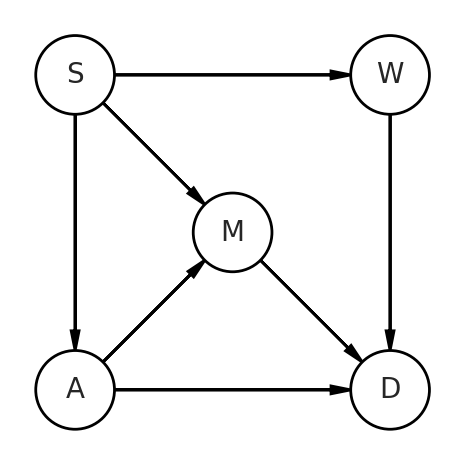

<IPython.core.display.Javascript object>

In [4]:
wh_dag = CausalGraphicalModel(
    nodes=["S", "W", "A", "M", "D"],
    edges=[
        ("S", "W"),
        ("S", "M"),
        ("S", "A"),
        ("A", "M"),
        ("A", "D"),
        ("M", "D"),
        ("W", "D"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "S": (0, 0),
    "W": (2, 0),
    "A": (0, -2),
    "M": (1, -1),
    "D": (2, -2),
}
for node in wh_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in wh_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


Using the `causalgraphicalmodels` package to get conditional independence relationships. Following documentation [here](https://github.com/ijmbarr/causalgraphicalmodels/blob/master/notebooks/cgm-examples.ipynb).


In [5]:
# get all the conditional independence relationships implied by a CGM
wh_dag.get_all_independence_relationships()

[('S', 'D', {'A', 'M', 'W'}),
 ('A', 'W', {'S'}),
 ('A', 'W', {'M', 'S'}),
 ('M', 'W', {'S'}),
 ('M', 'W', {'A', 'S'})]

<IPython.core.display.Javascript object>

Interesting that R daggity package only shows lines 1, 3, and 5. Why is it different?

Line 2 is showing simultaneous inclusion of M and S. It opens the collider (M) but it doesn't matter because it closes S. This shows more than it needs to.

How to say this?

For the first line:
- "W and A are independent, conditioning on S." (equivalent to say "A and W are independent, conditioning on S.")
- "W and A are d-separated, conditioning on S." (d-separated = dependency separated = awkward way of saying independent)


Doesn't give the backdoor path of W to D. Still have to figure this out. Maybe I can use d-separation function.

In [6]:
# check for d-seperation of two nodes
wh_dag.is_d_separated("D", "W", {"S"})

False

<IPython.core.display.Javascript object>

I expected this to show True! Why isn't it working?

In [7]:
# check for d-seperation of two nodes
wh_dag.is_d_separated("A", "W", {"S"})

True

<IPython.core.display.Javascript object>

In [8]:
# check for d-seperation of two nodes - maybe I need to account for all collider/path combinations??
wh_dag.is_d_separated("D", "W", {"A", "M"})

False

<IPython.core.display.Javascript object>

In [9]:
# get all the conditional independence relationships implied by a CGM
wh_dag.get_all_backdoor_paths("W", "D")

[['W', 'S', 'M', 'A', 'D'],
 ['W', 'S', 'M', 'D'],
 ['W', 'S', 'A', 'M', 'D'],
 ['W', 'S', 'A', 'D']]

<IPython.core.display.Javascript object>

## Setup

In [10]:
DATA_DIR = "/Users/blacar/Documents/ds_projects/stats_rethinking/data/a_input/"
df_div = pd.read_csv(os.path.join(DATA_DIR, "WaffleDivorce.csv"), sep=';')
df_div.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


<IPython.core.display.Javascript object>

I've found it helpful to simply sketch out the paths on one line.

(1) W < S > M > D

(2) W < S > A > D

(3) W < S > A > M > D

If I have the above DAG, which was given in the class. The simplest thing is to condition on S. S is one backdoor path that starts at as open since it is a fork. Leaving it in would lead to "common-cause confounding bias" (Elwert and Winship, 2014).

A more complicated way would be to leave S open. This would allow paths through A and M. Therefore, you need to close both (include both A and M in the model).


Another valid path:

(3) W < S > M < A  > D

**However, this is blocked by a collider.**

If I didn't have a DAG??? (not sure if this is possible)

Strategy:
- Create different models
- One with all variables (D, A, M, W) ... W = number of waffle houses
- Some with two
- Others with one only


Here's what I'll do:

1. Totally naive strategy is to include everything, predicting D
2. Include only S in the model


In [11]:
df_div.columns

Index(['Location', 'Loc', 'Population', 'MedianAgeMarriage', 'Marriage',
       'Marriage SE', 'Divorce', 'Divorce SE', 'WaffleHouses', 'South',
       'Slaves1860', 'Population1860', 'PropSlaves1860'],
      dtype='object')

<IPython.core.display.Javascript object>

In [12]:
df_div['Marriage'].head()

0    20.2
1    26.0
2    20.3
3    26.4
4    19.1
Name: Marriage, dtype: float64

<IPython.core.display.Javascript object>

In [15]:
# standardise the data
df_div["s_Age"] = standardize(df_div["MedianAgeMarriage"])
df_div["s_Marriage"] = standardize(df_div["Marriage"])
df_div["s_Divorce"] = standardize(df_div["Divorce"])
df_div['s_WaffleHouses'] = standardize(df_div['WaffleHouses'])   # not sure if I need to standardize?
df_div.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,s_Age,s_Marriage,s_Divorce,s_WaffleHouses
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,4.137349,14.850154,7.325284,127.503442
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,4.037349,20.650154,7.125284,-0.496558
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,4.637349,14.950154,5.425284,17.503442
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,3.137349,21.050154,8.125284,40.503442
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,5.637349,13.750154,2.625284,-0.496558


<IPython.core.display.Javascript object>

## Data exploration

Generate pair plots

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


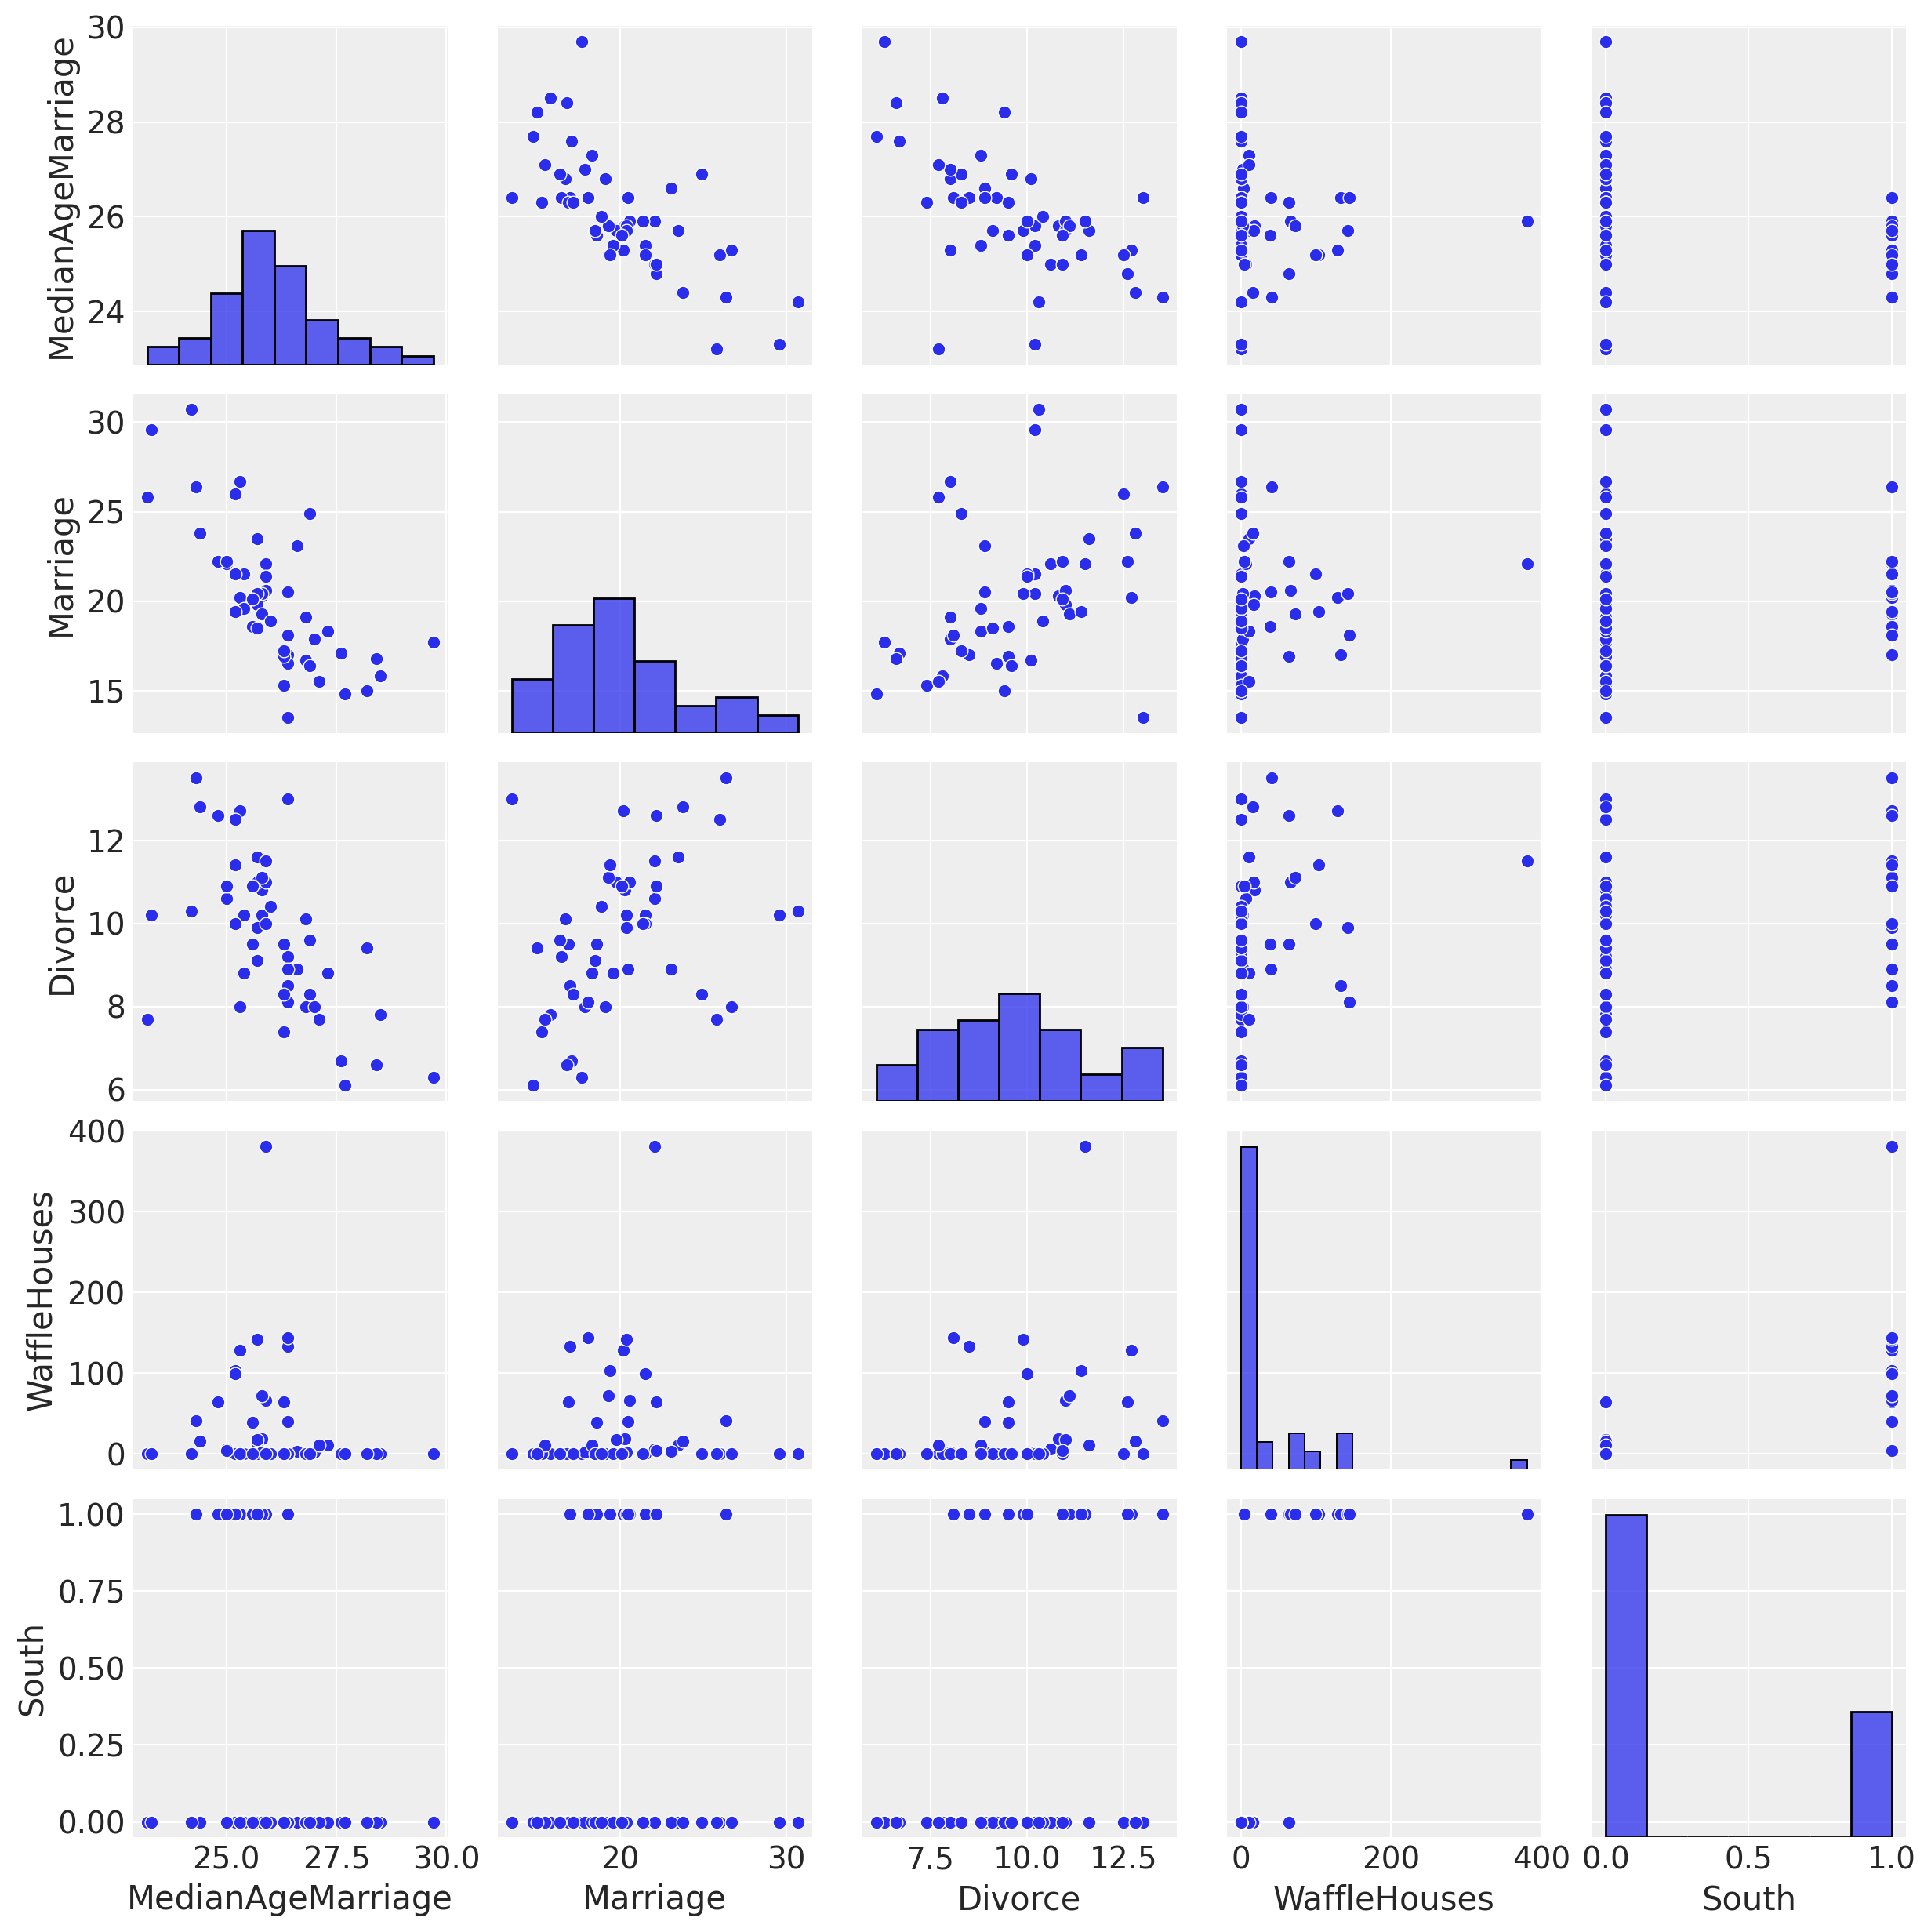

<IPython.core.display.Javascript object>

In [16]:
sns.pairplot(
    df_div[["MedianAgeMarriage", "Marriage", "Divorce", "WaffleHouses", "South"]]
)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


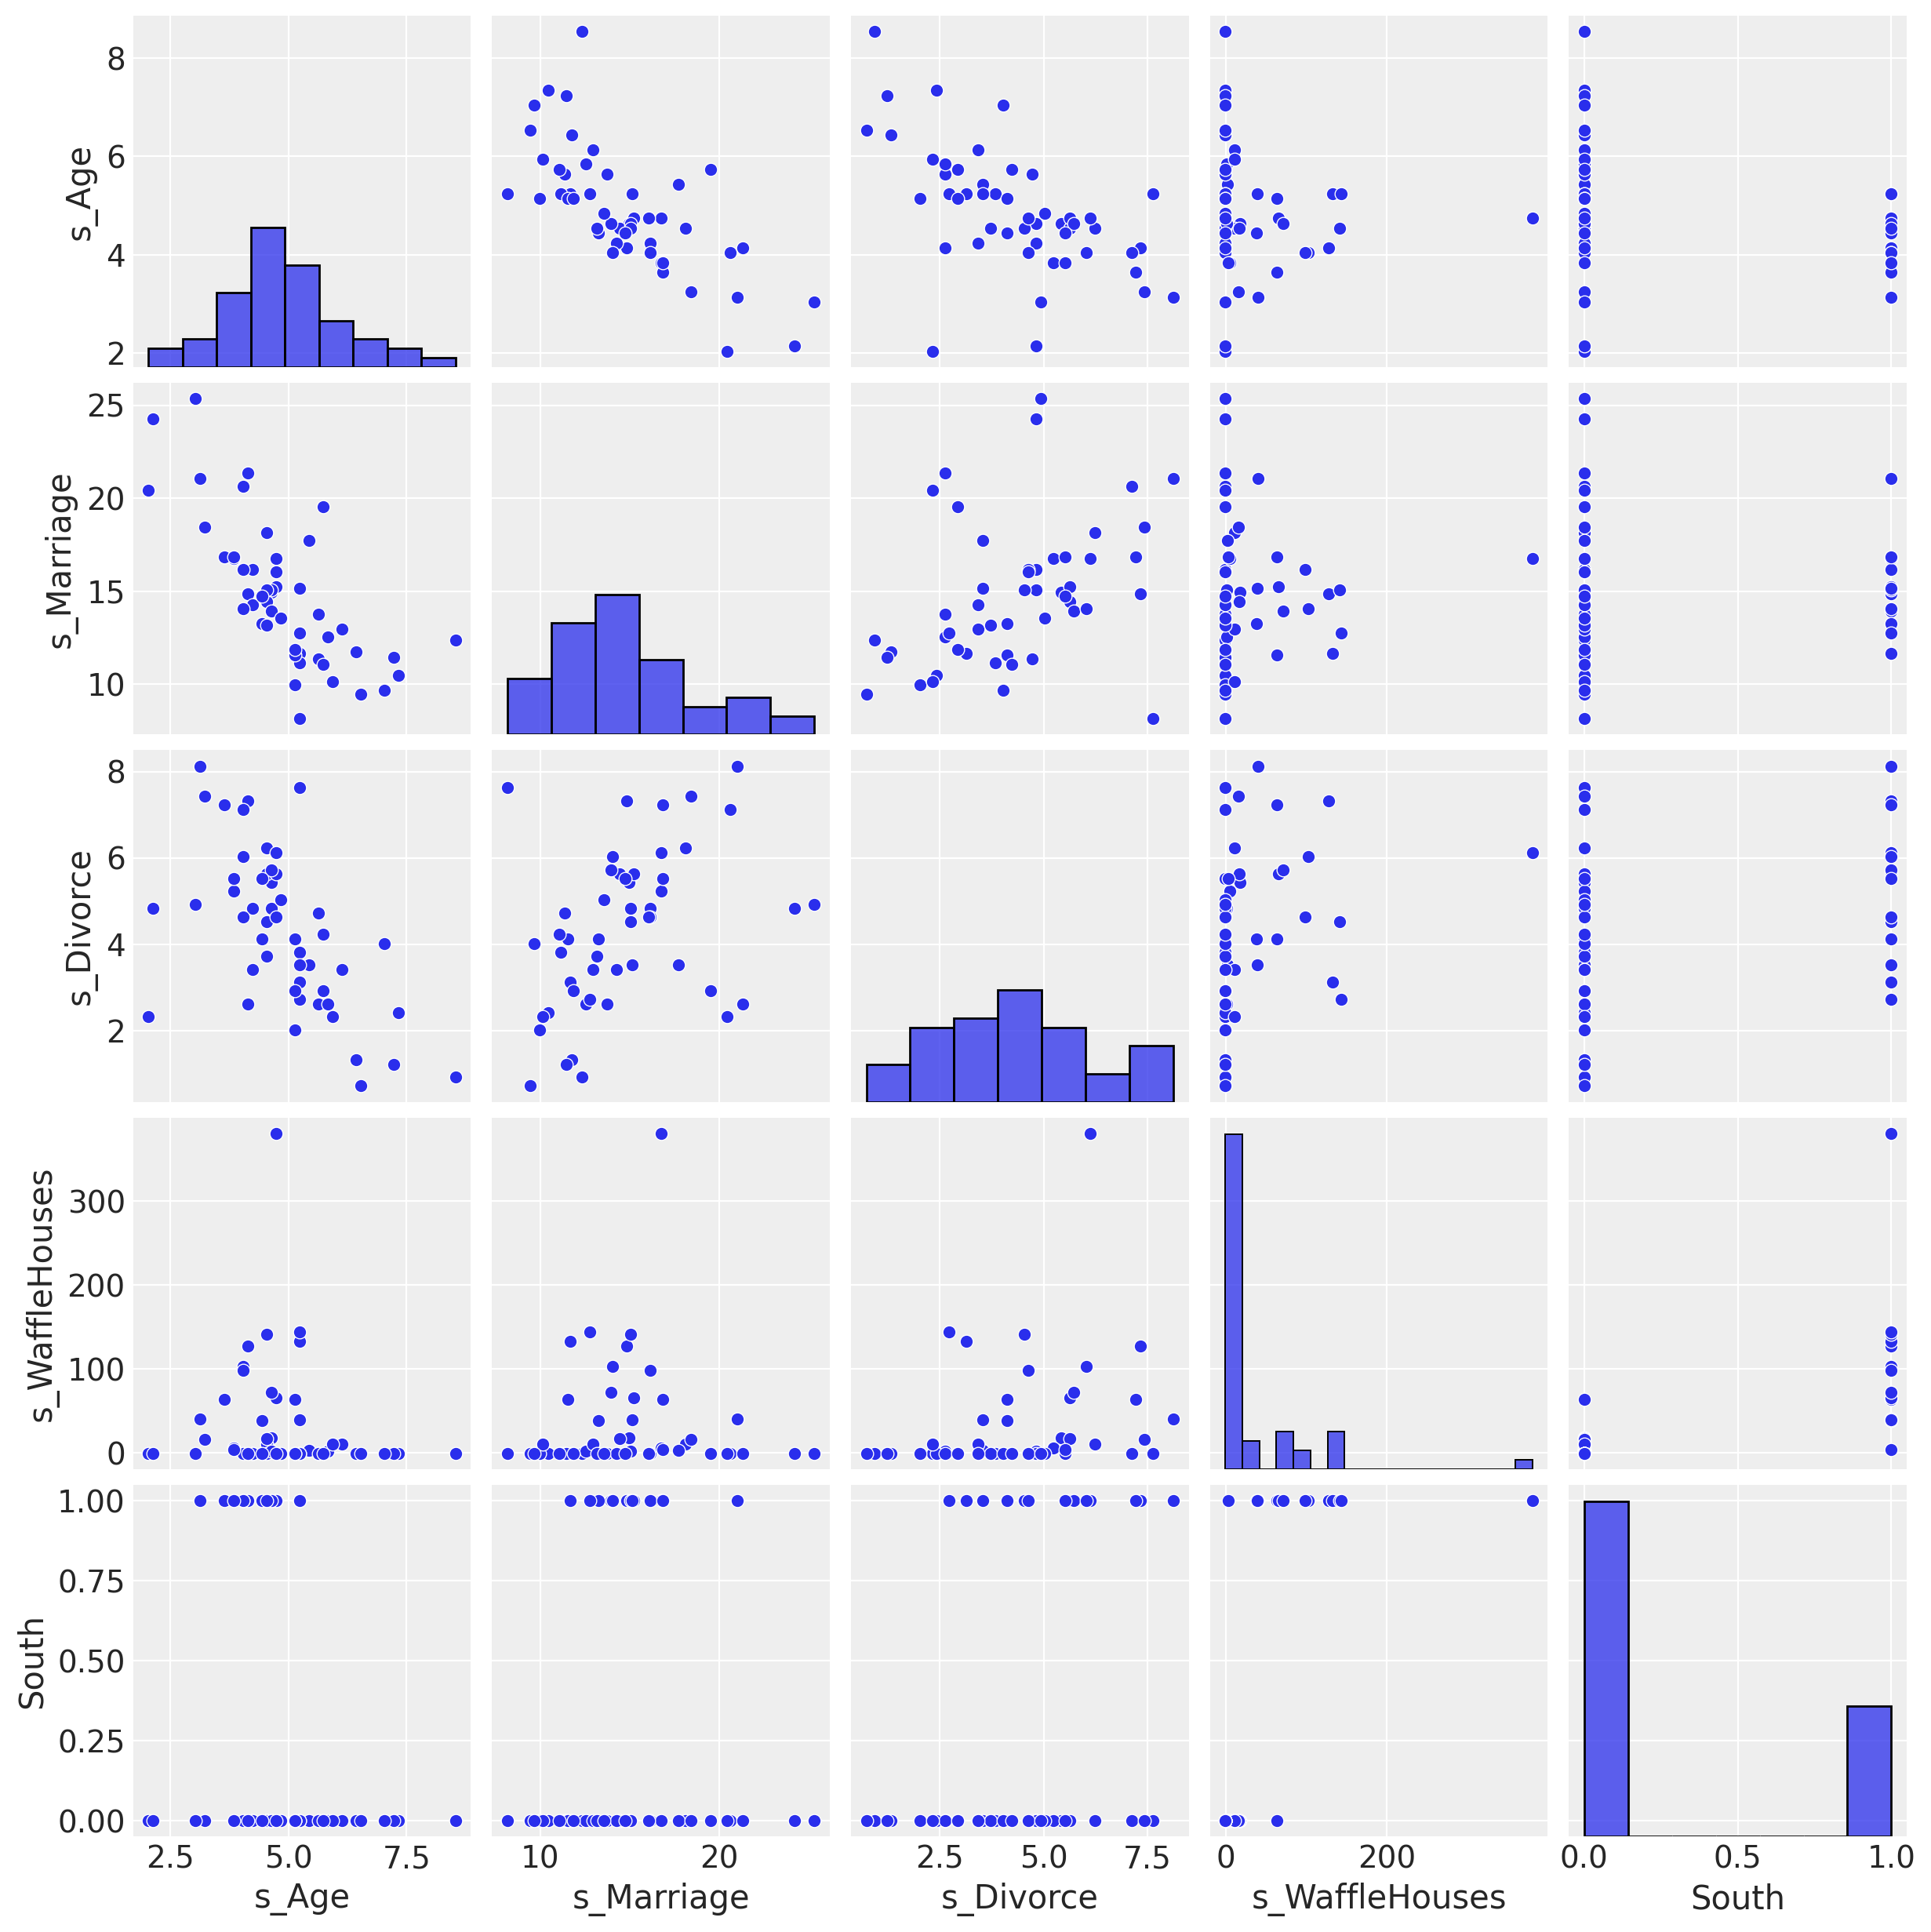

<IPython.core.display.Javascript object>

In [17]:
# Standardized
sns.pairplot(df_div[['s_Age', 's_Marriage', 's_Divorce', 's_WaffleHouses', 'South']])

## Testing model for syntax

Just use age to predict divorce rate

In [18]:
df_div.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,s_Age,s_Marriage,s_Divorce,s_WaffleHouses
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,4.137349,14.850154,7.325284,127.503442
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,4.037349,20.650154,7.125284,-0.496558
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,4.637349,14.950154,5.425284,17.503442
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,3.137349,21.050154,8.125284,40.503442
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,5.637349,13.750154,2.625284,-0.496558


<IPython.core.display.Javascript object>

I have this separate section as I'm reviewing syntax. Comparing with the repo, it looks like the dataframe doesn't have to be referenced. However, I decided to include it here for clarity. I'm also using different variables.

They used `sd` for standardized divorce rate, but I'll use `df_div['s_Divorce']` instead.

Other syntax
```
with pm.Model() as heights_model:

    # Priors are variables a, b, sigma
    # using pm.Normal is a way to represent the stochastic relationship the left has to right side of equation
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)

    # This is a linear model (not really a prior or likelihood?)
    # Data included here (d2.weight, which is observed)
    # Mu is deterministic, but a and b are stochastic
    mu = a + b * (d2.weight - xbar)

    # Likelihood is height variable, which is also observed (data included here, d2.height))
    # Height is dependent on deterministic and stochastic variables
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

    # The next lines is doing the fitting and sampling all at once.
    trace_m1 = pm.sample(1000, tune=1000, return_inferencedata=True)
    
```

In [19]:
with pm.Model() as Waffle_Model_test:
    a = pm.Normal("a", mu=0, sd=0.2)
    ba = pm.Normal("ba", mu=0, sd=0.5)
    xa = pm.Data("xa", df_div["s_Age"])
    mu_div = pm.Deterministic("mu", a + ba * xa)
    sigma_div = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu=mu_div, sd=sigma_div, observed=df_div["s_Divorce"])
    sample_all = pm.sample(draws=250, chains=4, return_inferencedata=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ba, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

## Testing model for categorical and continuous variable

Using south and number of waffle houses

In [42]:
df_div.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,s_Marriage,s_Divorce,s_WaffleHouses,s_Age
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,14.850154,7.325284,127.503442,4.137349
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,20.650154,7.125284,-0.496558,4.037349
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,14.950154,5.425284,17.503442,4.637349
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,21.050154,8.125284,40.503442,3.137349
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,13.750154,2.625284,-0.496558,5.637349


<IPython.core.display.Javascript object>

In [52]:
df_div["South"].unique()

array([1, 0])

<IPython.core.display.Javascript object>

In [21]:
# standardise the data
sw, sd = standardize(df_div.WaffleHouses), standardize(df_div.Divorce)

<IPython.core.display.Javascript object>

In [68]:
# Regression for the categorical variables
with pm.Model() as Waffle_south:
    a = pm.Normal("a", mu=0, sd=0.2, shape=2)
    b = pm.Normal("b", mu=0, sd=0.5, shape=2)
    x = pm.Data("x", sw)
    cid = pm.intX(pm.Data("cid", df_div["South"]))
    mu = pm.Deterministic("mu", a[cid] + b[cid] * x)
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu=mu, sd=sigma, observed=sd)
    sample_south = pm.sample(draws=250, chains=4, return_inferencedata=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

In [72]:
# Regression for the categorical variables
with pm.Model() as Waffle_south:
    a = pm.Normal("a", mu=0, sd=0.2, shape=2)
    bw = pm.Normal("bw", mu=0, sd=0.5, shape=2)
    xw = pm.Data("xw", sw)
    cid_s = pm.intX(pm.Data("cid_s", df_div["South"]))
    mu = pm.Deterministic("mu", a[cid_s] + bw[cid_s] * xw)
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu=mu, sd=sigma, observed=sd)
    sample_south = pm.sample(draws=250, chains=4, return_inferencedata=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bw, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

In [70]:
# Regression for all the data - took this code from repo
with pm.Model() as Waffle_Model_cat:
    a = pm.Normal("a", mu=0, sd=0.2)

    # No. of waffle houses
    bw = pm.Normal("bw", mu=0, sd=0.5)
    # xw = pm.Data("xw", df_div["s_WaffleHouses"])
    # xw = pm.Data("xw", df_div["s_WaffleHouses"])
    xw = pm.Data("xw", sw)

    # South, as a categorical variable
    cid = pm.intX(pm.Data("cid", df_div["South"]))

    # Mu and sigma
    mu_div = pm.Deterministic("mu_div", a[cid] + bw[cid] * xw)
    sigma_div = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu=mu_div, sd=sigma_div, observed=sd)
    # div = pm.Normal("div", mu=mu_div, sd=sigma_div, observed=df_div["Divorce"])

    sample_cat = pm.sample(draws=250, chains=4, return_inferencedata=True)

IndexError: too many indices for array

<IPython.core.display.Javascript object>

## Bad model: include all variables

In [49]:
# Regression for all the data - took this code from repo
with pm.Model() as Waffle_Model_all:
    a = pm.Normal("a", mu=0, sd=0.2)

    # Age
    ba = pm.Normal("ba", mu=0, sd=0.5)
    xa = pm.Data("xa", df_div["s_Age"])

    # Marriage
    bm = pm.Normal("bm", mu=0, sd=0.5)
    xm = pm.Data("xm", df_div["s_Marriage"])

    # No. of waffle houses
    bw = pm.Normal("bw", mu=0, sd=0.5)
    xw = pm.Data("xw", df_div["s_WaffleHouses"])

    # South, as a categorical variable    <--- not sure if this is right syntax
    bs = pm.Normal("bs", mu=0, sd=0.5)
    x_sid = pm.intX(pm.Data("x_sid", df_div["South"]))

    # Mu and sigma
    mu_div = pm.Deterministic("mu", a[x_sid] + ba[x_sid] * xa + bm * xm + bw * xw + bs[x_sid] * x_sid)
    sigma_div = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu=mu_div, sd=sigma_div, observed=df_div["s_Divorce"])

    sample_all = pm.sample(draws=250, chains=4, return_inferencedata=True)

IndexError: too many indices for array

<IPython.core.display.Javascript object>

## Good model: condition on S only

In [23]:
# Regression for the categorical variables
with pm.Model() as Waffle_south:
    a = pm.Normal("a", mu=0, sd=0.2, shape=2)
    bw = pm.Normal("bw", mu=0, sd=0.5, shape=2)
    xw = pm.Data("xw", sw)
    cid_s = pm.intX(pm.Data("cid_s", df_div["South"]))
    mu = pm.Deterministic("mu", a[cid_s] + bw[cid_s] * xw)
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu=mu, sd=sigma, observed=sd)
    sample_south = pm.sample(draws=250, chains=4, return_inferencedata=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bw, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 13 seconds.


<IPython.core.display.Javascript object>

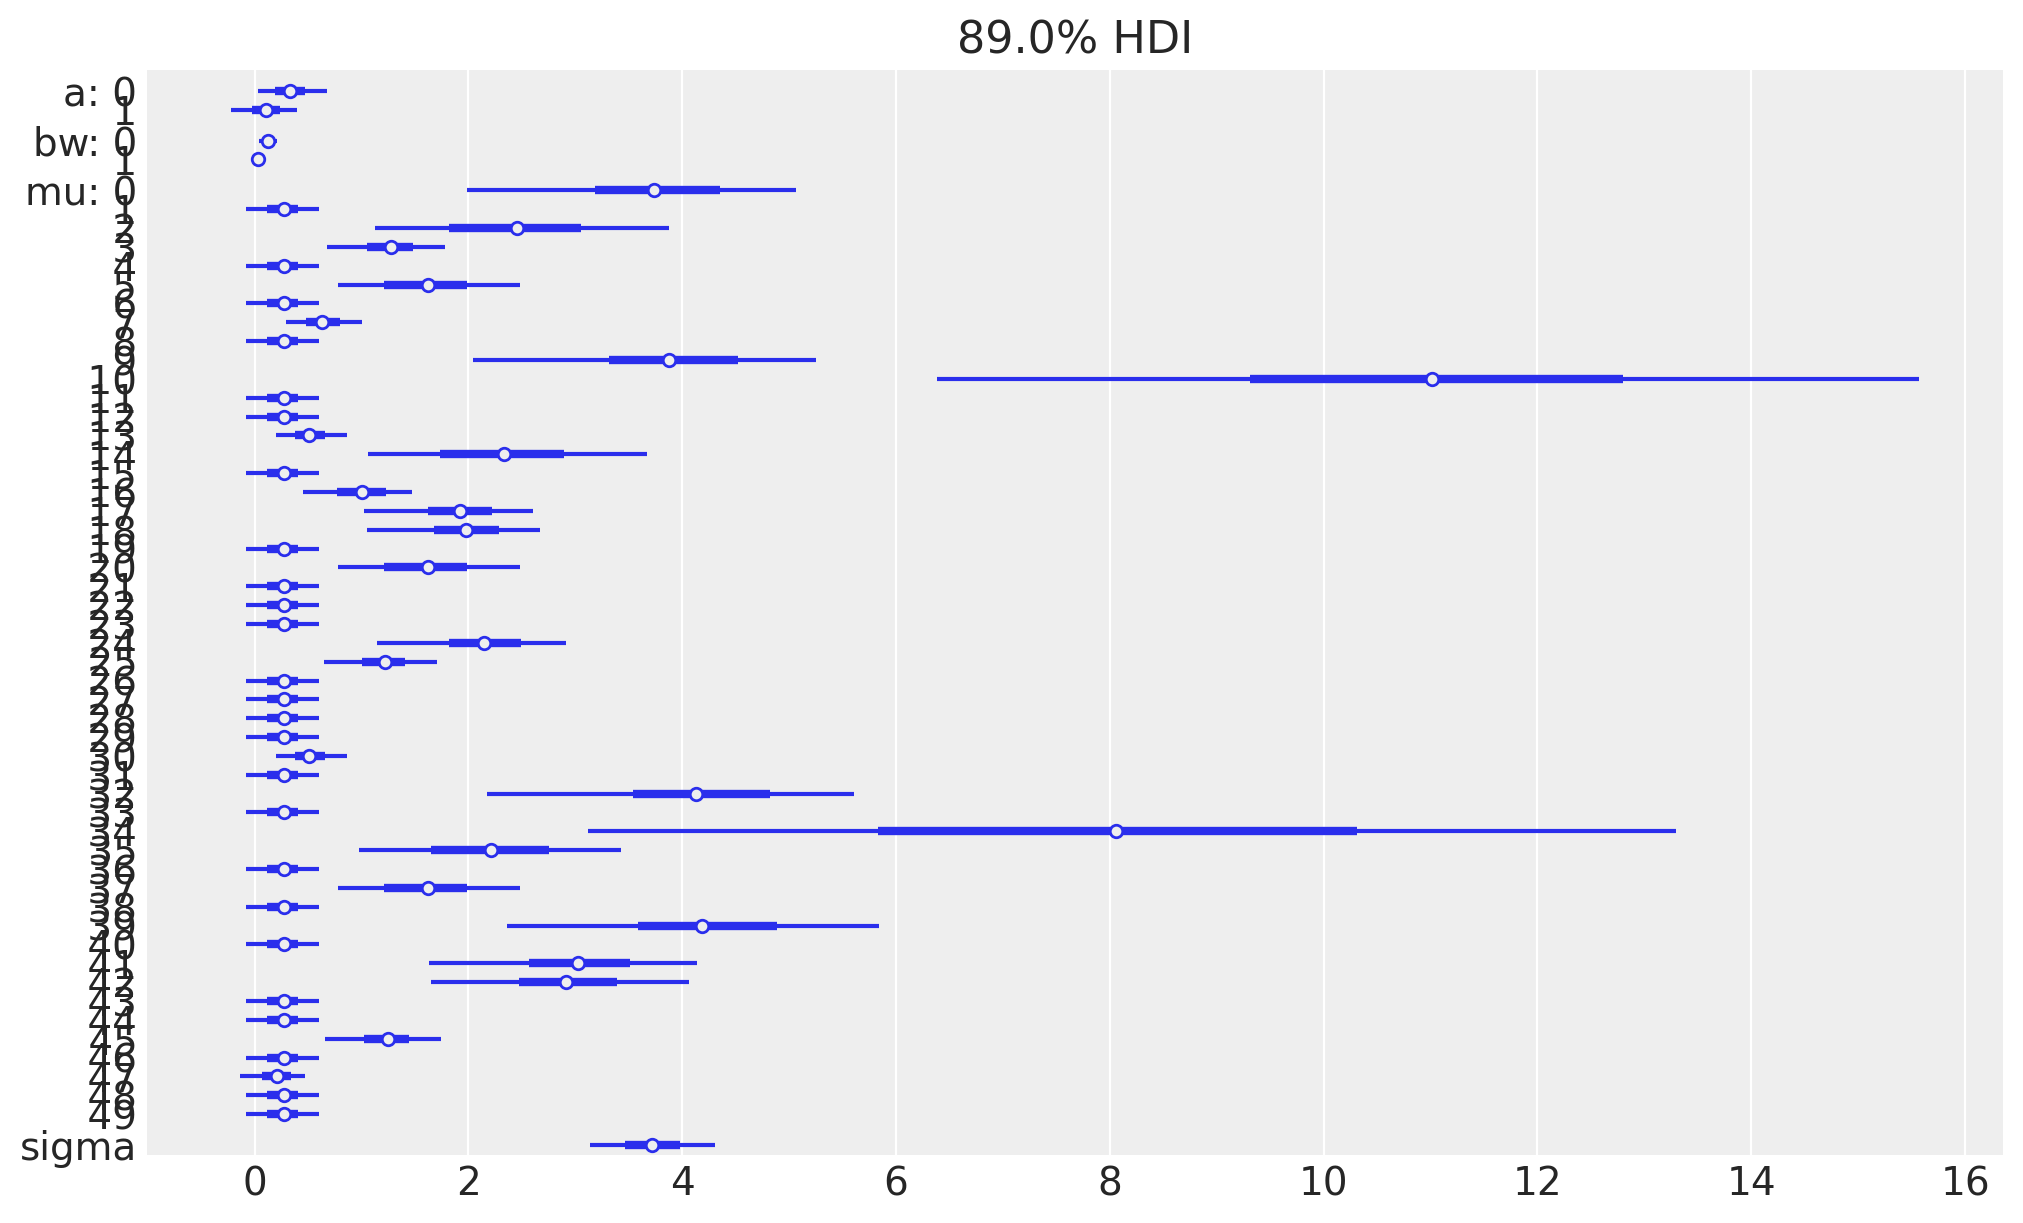

<IPython.core.display.Javascript object>

In [28]:
# _ = az.plot_forest(sample, var_names=["~mu"], combined=True, figsize=[5, 2])
_ = az.plot_forest(sample_south, combined=True, figsize=[10, 6])

In [25]:
# _ = az.plot_forest(sample, var_names=["~mu"], combined=True, figsize=[5, 2])
az.summary(sample_south)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],0.325,0.209,0.028,0.680,0.006,0.005,1107.0,887.0,1105.0,749.0,1.01
a[1],0.106,0.195,-0.218,0.395,0.006,0.006,998.0,501.0,1002.0,672.0,1.01
bw[0],0.122,0.052,0.044,0.207,0.001,0.001,1378.0,1233.0,1377.0,754.0,1.00
bw[1],0.029,0.008,0.015,0.039,0.000,0.000,1069.0,979.0,1094.0,526.0,1.00
mu[0],3.751,0.952,1.988,5.066,0.028,0.021,1180.0,1064.0,1208.0,576.0,1.00
mu[1],0.264,0.215,-0.081,0.599,0.006,0.005,1094.0,910.0,1101.0,747.0,1.01
mu[2],2.468,0.895,1.125,3.876,0.025,0.019,1309.0,1154.0,1302.0,710.0,1.00
mu[3],1.264,0.341,0.680,1.780,0.009,0.007,1397.0,1226.0,1433.0,544.0,1.00
mu[4],0.264,0.215,-0.081,0.599,0.006,0.005,1094.0,910.0,1101.0,747.0,1.01
mu[5],1.611,0.549,0.778,2.485,0.016,0.012,1185.0,1062.0,1147.0,690.0,1.00


<IPython.core.display.Javascript object>

# Appendix: Environment and system parameters

In [12]:
%watermark -n -u -v -iv -w

Last updated: Thu Feb 18 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

numpy     : 1.20.1
matplotlib: 3.3.4
arviz     : 0.11.1
pandas    : 1.2.1
seaborn   : 0.11.1
json      : 2.0.9
pymc3     : 3.11.0
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>

In [13]:
# Custom scripts to show packages and versions in this notebook
def imports():
    import types

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__


imported_packages = list(imports())

from active_pkg import show_pkg_vers_in_nb

show_pkg_vers_in_nb(imported_packages)

# Name                    Version                   Build  Channel
arviz                     0.11.1                   pypi_0    pypi
matplotlib                3.3.4                    pypi_0    pypi
numpy                     1.20.1                   pypi_0    pypi
pandas                    1.2.1                    pypi_0    pypi
pymc3                     3.11.0                   pypi_0    pypi
scipy                     1.6.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi


<IPython.core.display.Javascript object>